In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset

from torchvision.transforms import v2
import torchvision.utils as vutils
from torchvision import datasets

from pytorchsummary import summary

The github repository og the GAIN author is found here: https://github.com/jsyoon0823/GAIN/blob/master/gain.py

The networks (both discriminator and generator) have a very simple structure

In [22]:
batch_size = 128

transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: 2*x - 1)] 
    )

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Getting a subset of the data for speed purposes
num_samples = 60000
indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [23]:
# Discriminator class
class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(), 
            nn.Linear(64 * 4 * 4, 1),  # Assuming input is 28x28, this will be flattened to 1024
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    

# Generator class
class GeneratorConv(nn.Module):
    def __init__(self, z_dimension):
        super(GeneratorConv, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(z_dimension, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 7, 7)),  # 7 because it divides 28 (mnist resolution)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  
        )

    def forward(self, z):
        return self.network(z)

class GAN(nn.Module):
    pass
    def __init__(self, generator, discriminator, latent_dimension, lossfunction):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lossfunction = lossfunction
        self.latent_dimension = latent_dimension #?


    def forward_discriminator(self):
        pass

    def forward_generator(self):
        pass

    def forward(self):
        self.forward_discriminator()
        self.forward_generator()

    def save_parameters(self):
        torch.save(self.generator.state_dict(), "generate_1.pth")
        torch.save(self.discriminator.state_dict(), "discriminate_1.pth")

    def print_layer_summary(self):
        summary(model=self.generator, input_size=(1, self.latent_dimension))
        summary(model=self.discriminator, input_size=(1, 28, 28))

In [26]:
lr_discriminator = 2e-4
lr_generator = 4e-4
epochs = 10
noise_dimension = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


lossfunction = nn.BCELoss()

generate = GeneratorConv(noise_dimension).to(device)
discriminate = DiscriminatorConv().to(device)

optimizer_gen = optim.Adam(generate.parameters(), lr=lr_generator, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(discriminate.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))

noise_general = torch.randn(noise_dimension, noise_dimension, device=device)

discriminate_loss, generate_loss = [], []
epoch_current = 0

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(discriminate), count_parameters(generate)


(24513, 584449)

Epoch [1/30] - 3.33% complete | Discriminator Loss: 1.2559 | Generator Loss: 0.8191 | Time: 122.77s
Epoch [2/30] - 6.67% complete | Discriminator Loss: 1.0456 | Generator Loss: 1.0102 | Time: 130.27s
Epoch [3/30] - 10.00% complete | Discriminator Loss: 1.0509 | Generator Loss: 1.0239 | Time: 130.21s
Epoch [4/30] - 13.33% complete | Discriminator Loss: 1.0529 | Generator Loss: 1.0309 | Time: 128.65s
Epoch [5/30] - 16.67% complete | Discriminator Loss: 1.0233 | Generator Loss: 1.0655 | Time: 129.13s
Epoch [6/30] - 20.00% complete | Discriminator Loss: 1.0362 | Generator Loss: 1.0731 | Time: 132.82s
Epoch [7/30] - 23.33% complete | Discriminator Loss: 1.0464 | Generator Loss: 1.0632 | Time: 133.46s
Epoch [8/30] - 26.67% complete | Discriminator Loss: 1.0590 | Generator Loss: 1.0507 | Time: 131.13s
Epoch [9/30] - 30.00% complete | Discriminator Loss: 1.0652 | Generator Loss: 1.0607 | Time: 119.42s
Epoch [10/30] - 33.33% complete | Discriminator Loss: 1.0720 | Generator Loss: 1.0560 | Time:

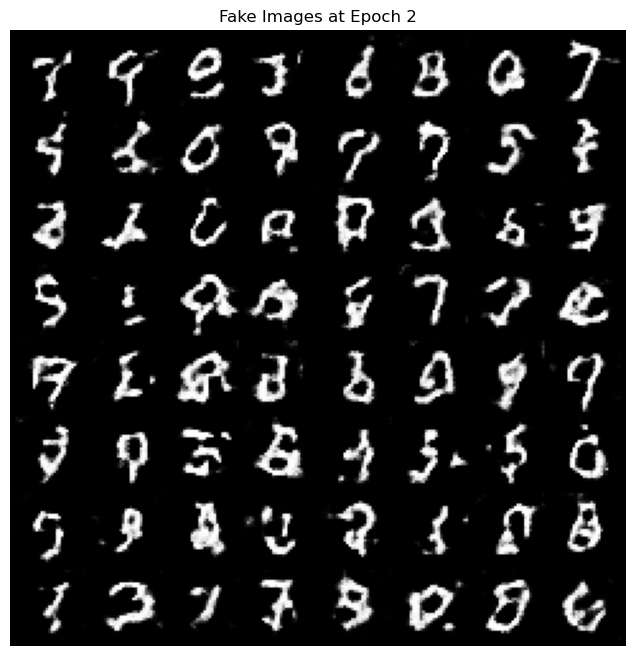

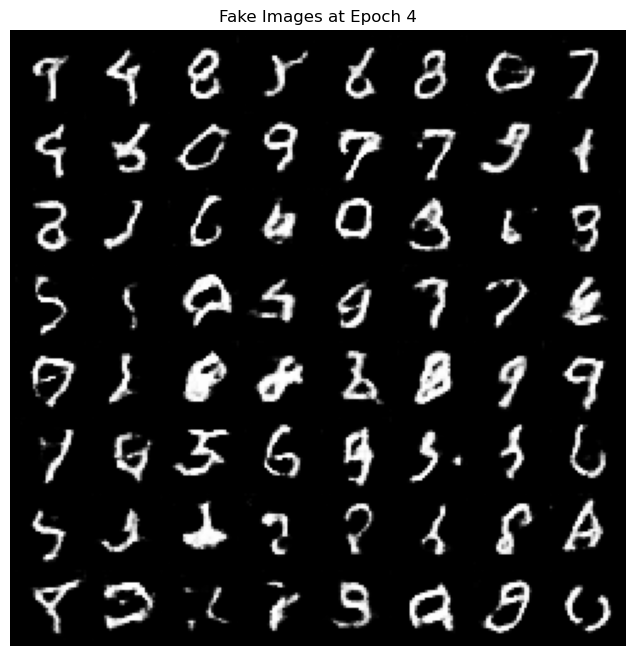

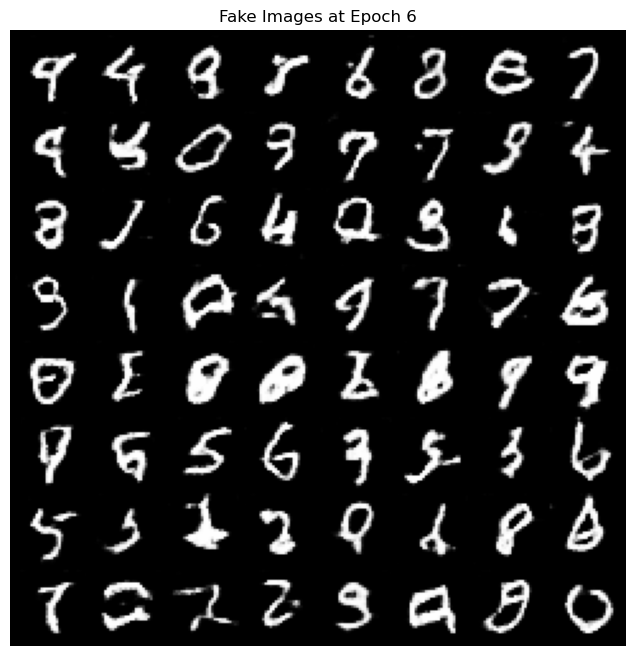

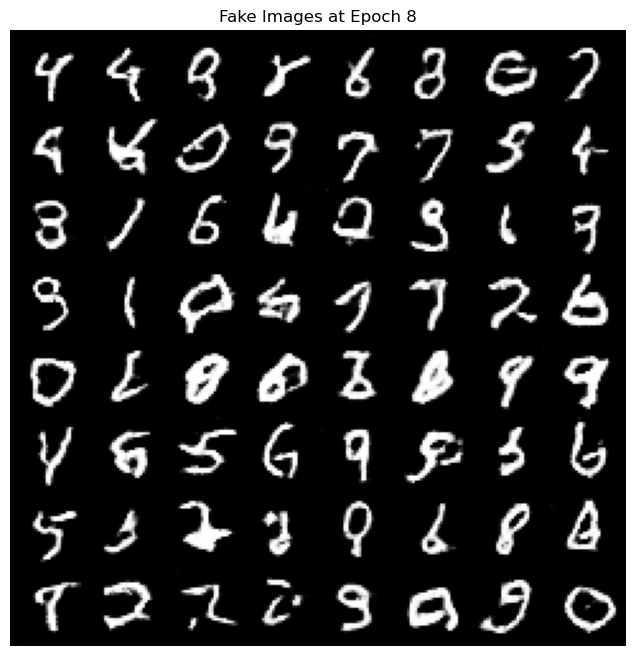

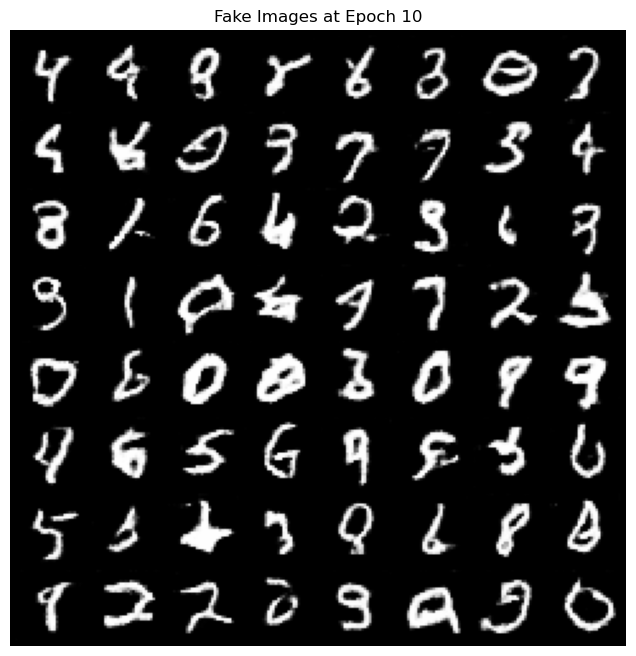

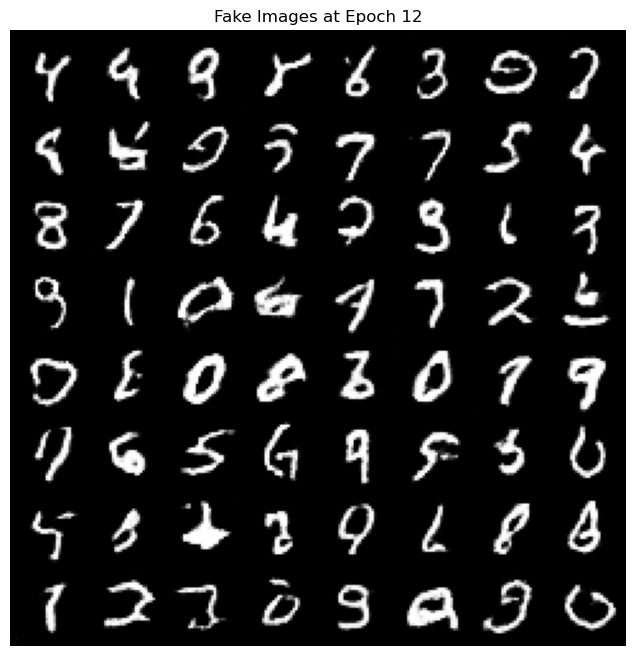

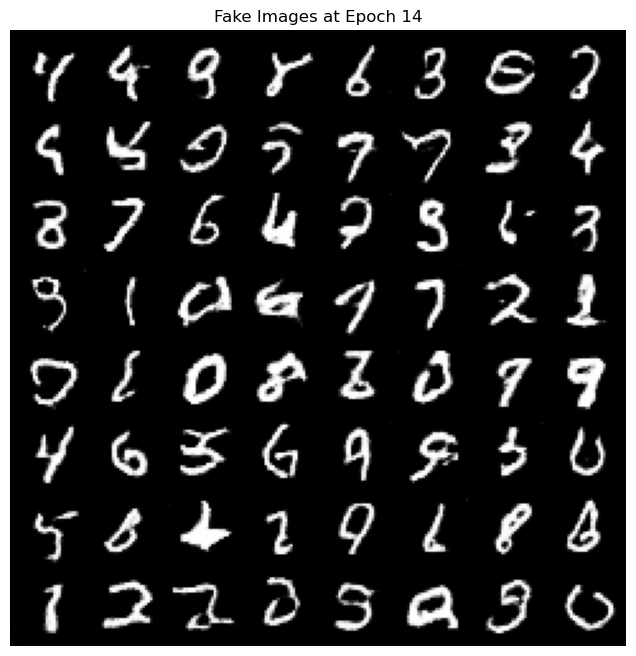

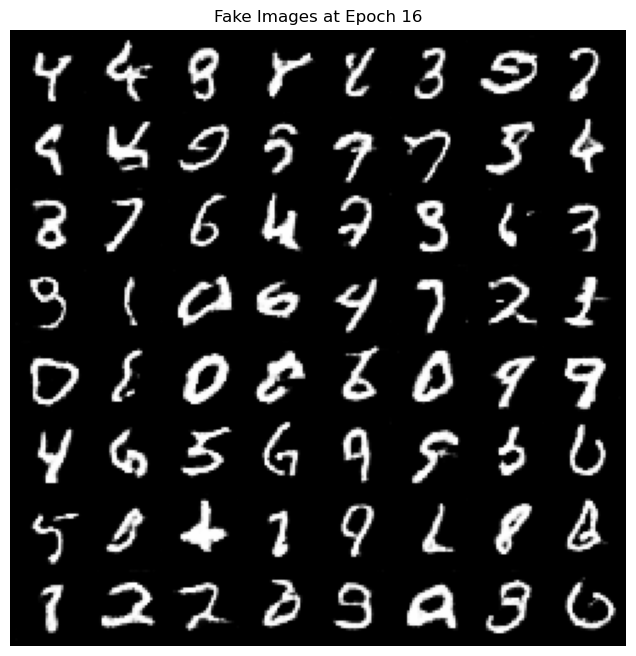

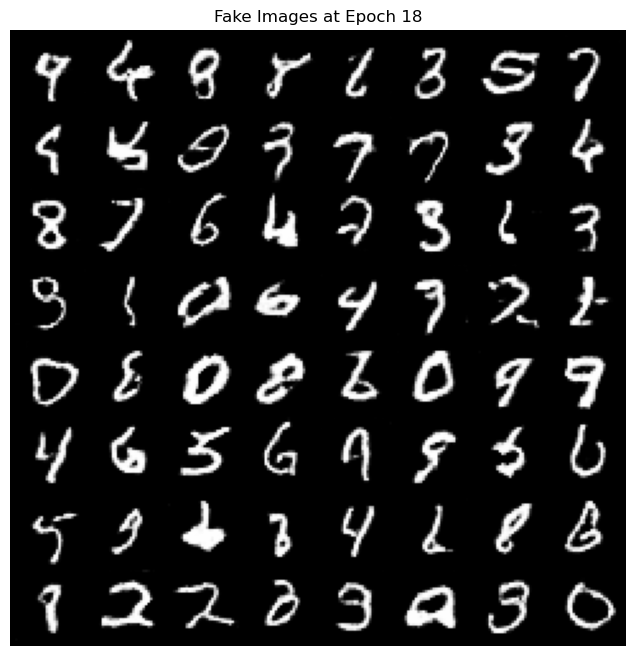

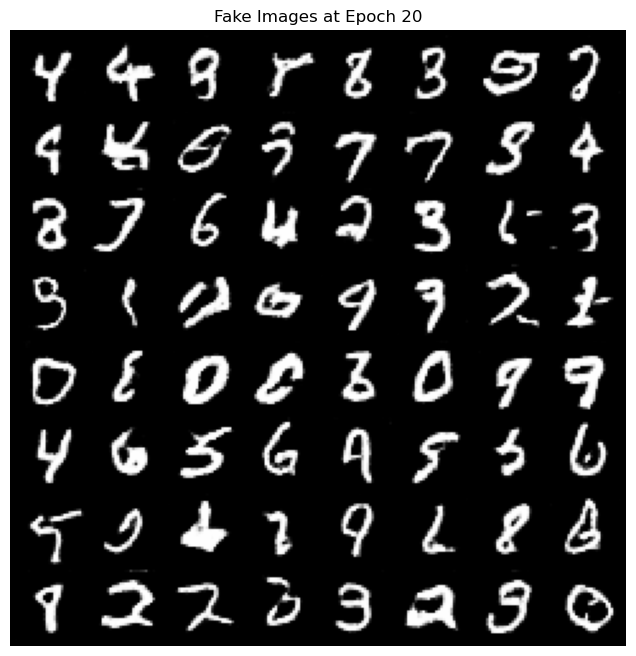

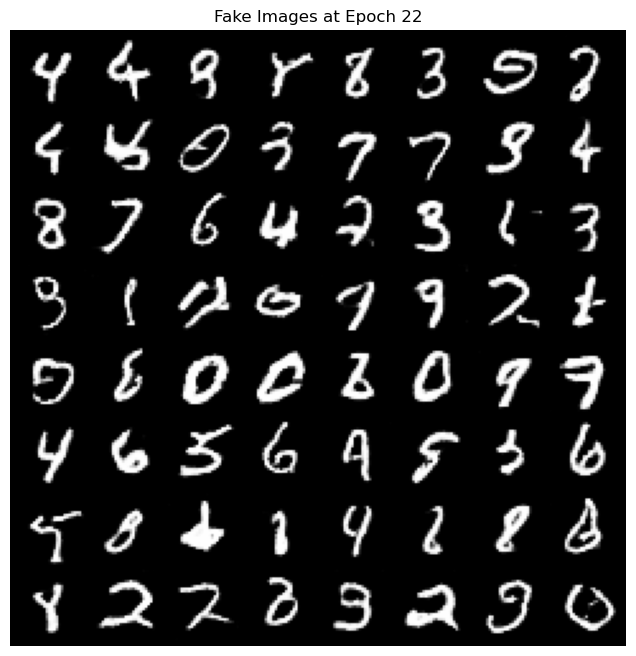

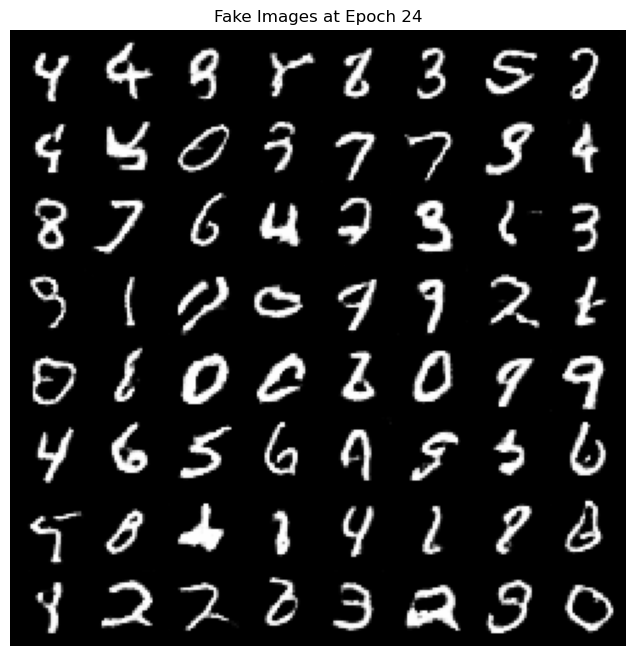

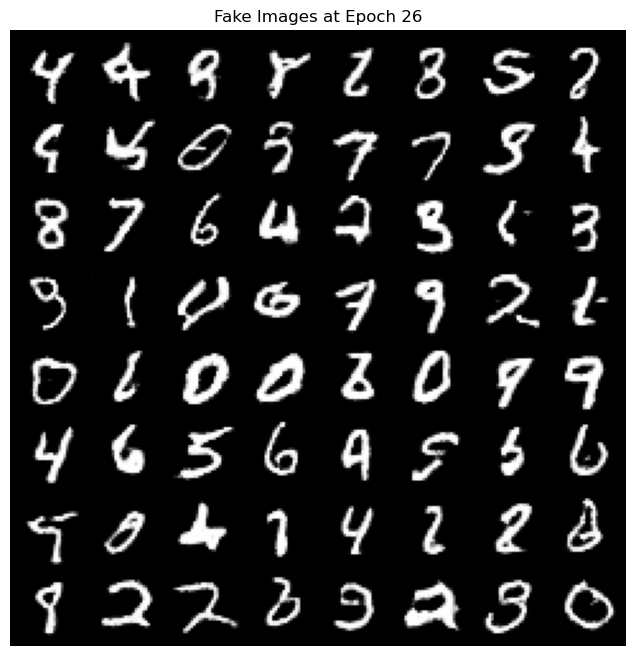

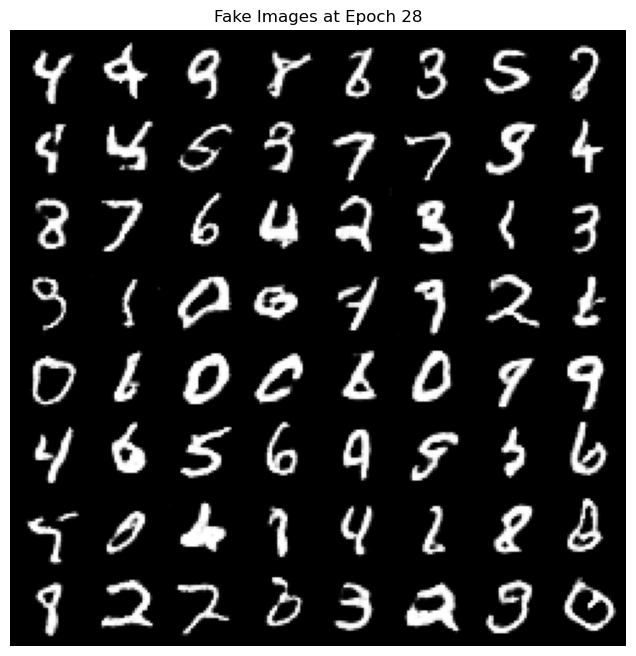

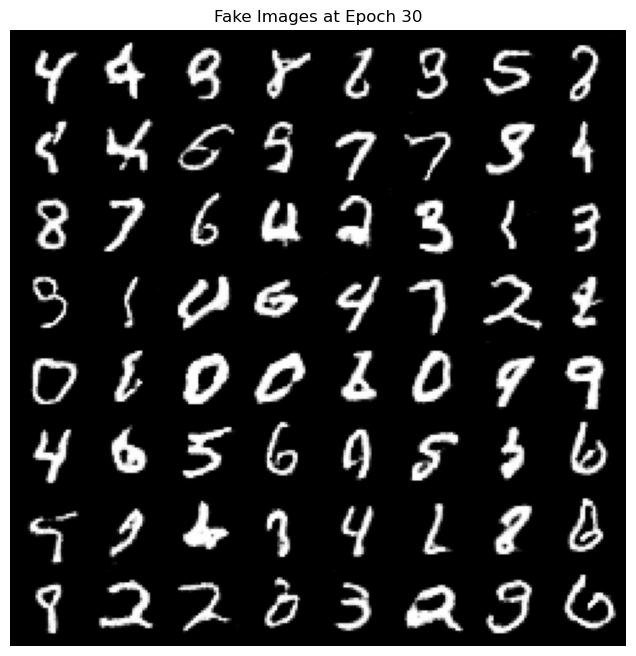

In [27]:
K = 1
epochs = 30

total_batches = len(train_loader)
real_label_noise = 0.95 + 0.05 * torch.rand(batch_size, 1, device=device) # I think I switched the labels.. and it works and does not work the other way around.. ???
fake_label_noise = 0.05 * torch.rand(batch_size, 1, device=device)

for epoch in range(epoch_current, epochs):
    start_time = time.time()

    # Initialize cumulative loss values for the epoch
    running_loss_disc = 0.0
    running_loss_gen = 0.0

    # Updating the Generator 
    for i, batch in enumerate(train_loader):

        ### Update the discriminator distribution. This van also be done (K=1) times. K is a hyperparameter in (Goodfellow, 2014)
        optimizer_disc.zero_grad()
        noise = torch.randn(batch_size, noise_dimension, device=device)

        real_images = batch[0].to(device)
        fake_images = generate(noise).detach() # detach() so that gradients are not passed back to the generator when updating the discriminator.
        real_images_disc = discriminate(real_images)
        fake_images_disc = discriminate(fake_images)

        # Computing the loss function (As in Algorithm 1 in Goodfellow)
        loss_data = lossfunction(real_images_disc, fake_label_noise)        # E log   D(  x)
        loss_generated = lossfunction(fake_images_disc, real_label_noise)   # E log(1-D(G(z))
        loss_discriminator = loss_data + loss_generated

        # Keeping track of the loss and performing backward propagation
        running_loss_disc += loss_discriminator.item()
        loss_discriminator.backward()
        optimizer_disc.step()

        ### Updating the generator
        optimizer_gen.zero_grad()

        noise = torch.randn(batch_size, noise_dimension, device=device) # Does this one need to be different than the noise of beginning of loop?
        fake_images = generate(noise)
        fake_images_disc = discriminate(fake_images)
        loss_generator = lossfunction(fake_images_disc, torch.zeros(batch_size, 1, device=device))

        loss_generator.backward()
        optimizer_gen.step()

        running_loss_gen += loss_generator.item()

    avg_loss_disc = running_loss_disc / (K * total_batches)
    avg_loss_gen = running_loss_gen / total_batches

    discriminate_loss.append(avg_loss_disc)
    generate_loss.append(avg_loss_gen)
    
    # Display the epoch progress
    progress = (epoch + 1) / epochs * 100
    print(f"Epoch [{epoch + 1}/{epochs}] - {progress:.2f}% complete | "
          f"Discriminator Loss: {avg_loss_disc:.4f} | Generator Loss: {avg_loss_gen:.4f} | "
          f"Time: {time.time() - start_time:.2f}s")
    
    # Show every few epochs how the fixed noise is generates into new images and save it
    if (epoch+1) % 2 == 0:
        fake_images = generate(noise_general)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Fake Images at Epoch {epoch + 1}")
        plt.imshow(vutils.make_grid(fake_images[:64], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0)))
        plt.savefig(f"{os.getcwd()}/images/mnist_gam_Fake Images at Epoch {epoch + 1}.png")

    epoch_current += 1

In [ ]:

        # all_images = torch.cat([real_images, fake_images], axis=0)
        # all_images_disc = discriminate(all_images)
        # labels = torch.cat([real_label_noise, fake_label_noise])
        # loss_discriminator = lossfunction(all_images_disc, labels)

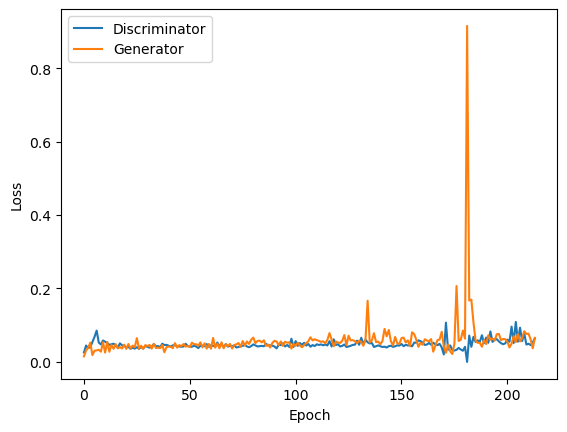

In [48]:
plt.plot(discriminate_loss[0:])
plt.plot(generate_loss[0:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Discriminator", "Generator"])
plt.show()